# Layer Experiment with Qwen3-0.6b

This notebook experiments with the smaller Qwen3-0.6b model (0.6b parameters, 28 layers) and tests how different layers affect LRE faithfulness.

In [26]:
import json
import random
from lre import LREModel
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display
import os
from data_utils import (
    load_json_files, 
    create_data_file_dropdown, 
    create_model_dropdown, 
    load_model_options, 
    fetch_model_layer_info,
    load_and_split_data,
    configure_template_and_print_summary,
    initialize_lre_model,
    get_layers_to_test,
    run_layer_experiment,
    plot_operator_eigenvalue_spectrum,
    plot_operator_svd_analysis,
    plot_pca_predictions,
    plot_pc1_projection_lines
)
import matplotlib.pyplot as plt

data_root = "data"
# Get all JSON files from all subdirectories under data/
json_files = load_json_files(data_root=data_root)

# Create dropdown for selecting a data file
data_file_dropdown = create_data_file_dropdown(json_files)
model_dropdown = create_model_dropdown(default_model="Qwen/Qwen3-0.6B")

# Fetch model layer info directly from model_config.json
models = load_model_options()
model_info = fetch_model_layer_info(
    models=models,
    output_file="model_layer_info.json",
    verbose=True
)

display(data_file_dropdown)
display(model_dropdown)

Found 47 relation files:
google/gemma-3-270m                      | Layers: 18   | Type: gemma3_text
google/gemma-3-1b-pt                     | Layers: 26   | Type: gemma3_text
gpt2                                     | Layers: 12   | Type: gpt2
gpt2-xl                                  | Layers: 48   | Type: gpt2
meta-llama/Llama-3.2-1B                  | Layers: 16   | Type: llama
mistralai/Mistral-7B-v0.3                | Layers: 32   | Type: mistral
Qwen/Qwen3-0.6B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-1.7B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-4B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-8B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-14B                           | Layers: 40   | Type: qwen3

Model information saved to: model_layer_info.json


Dropdown(description='Data File:', options=('bias/characteristic_gender.json', 'bias/degree_gender.json', 'bia…

Dropdown(description='Model:', index=6, options=('google/gemma-3-270m', 'google/gemma-3-1b-pt', 'gpt2', 'gpt2-…

In [18]:
# Fetch hidden state dimensions for all models
from transformers import AutoConfig

# Extract model names from the already-loaded model_info dictionary
model_names = list(model_info.keys())

model_hidden_dims = {}
print("Model Hidden State Dimensions:")
print("=" * 70)

for model_name in model_names:
    try:
        config = AutoConfig.from_pretrained(model_name)
        hidden_size = config.hidden_size
        model_hidden_dims[model_name] = hidden_size
        print(f"{model_name:<45} {hidden_size:>6}")
    except Exception as e:
        print(f"{model_name:<45} Error: {str(e)}")

print("=" * 70)
print(f"\nSmallest hidden dimension: {min(model_hidden_dims.values())}")
print(f"Largest hidden dimension: {max(model_hidden_dims.values())}")
print(f"\nRecommended xlim for consistent visualization: {max(model_hidden_dims.values())}")

Model Hidden State Dimensions:
google/gemma-3-270m                              640
google/gemma-3-1b-pt                            1152
gpt2                                             768
gpt2-xl                                         1600
meta-llama/Llama-3.2-1B                         2048
mistralai/Mistral-7B-v0.3                       4096
Qwen/Qwen3-0.6B                                 1024
Qwen/Qwen3-1.7B                                 2048
Qwen/Qwen3-4B                                   2560
Qwen/Qwen3-8B                                   4096
Qwen/Qwen3-14B                                  5120

Smallest hidden dimension: 640
Largest hidden dimension: 5120

Recommended xlim for consistent visualization: 5120


In [19]:
# Store the maximum hidden dimension for consistent plotting
MAX_HIDDEN_DIM = max(model_hidden_dims.values())
print(f"\nMAX_HIDDEN_DIM set to {MAX_HIDDEN_DIM} for consistent eigenvalue spectrum visualization")


MAX_HIDDEN_DIM set to 5120 for consistent eigenvalue spectrum visualization


In [20]:
# Create plots directory if it doesn't exist
import os
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)
print(f"Plots will be saved to: {PLOTS_DIR}/")

Plots will be saved to: plots/


In [ ]:
# Set consistent y-axis limits for eigenvalue plots
# Based on typical eigenvalue ranges for linear regression operators
YLIM_LOG = (1e-8, 1e2)  # For log scale plot (left subplot)
YLIM_LINEAR = (0, 100)  # For linear scale plot (right subplot - top 50 eigenvalues)
print(f"Eigenvalue plot y-axis limits set:")
print(f"  Log scale: {YLIM_LOG}")
print(f"  Linear scale: {YLIM_LINEAR}")

# Toggle for using consistent x-axis limits across all models
USE_CONSISTENT_XLIM = True  # Set to False for natural auto-scaling per plot
print(f"\nConsistent x-axis scaling: {'Enabled' if USE_CONSISTENT_XLIM else 'Disabled'}")
if USE_CONSISTENT_XLIM:
    print(f"  Using MAX_HIDDEN_DIM = {MAX_HIDDEN_DIM} for all plots")
else:
    print(f"  Each plot will auto-scale based on its eigenvalue count")

Eigenvalue plot y-axis limits set:
  Log scale: (1e-08, 100.0)
  Linear scale: (0, 100)


## 2. Load and Split Data Initialise model



In [5]:
# Initialize LRE model

MODEL_NAME = model_dropdown.value
lre = initialize_lre_model(MODEL_NAME, device="mps") # or "cuda" if GPU is available 

DATA_FILE = os.path.join(data_root, data_file_dropdown.value)
print(f"\nSelected data file: {DATA_FILE}")

# Load and split data using utility function
result = load_and_split_data(DATA_FILE, n_train=5, seed=42)

train_data = result['train_data']
test_data = result['test_data']

# Configuration for few-shot learning - use all training data
K_FOLD_SIZE = len(train_data)

# Configure template and print summary
TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")

Selected model: Qwen/Qwen3-0.6B
No HF_TOKEN found - proceeding without authentication
Loading Qwen/Qwen3-0.6B on mps...

Selected data file: data/bias/characteristic_gender.json
Dataset: characteristic gender
Template: {} is commonly associated with
Data: 5 train, 25 test


## 4. Layer-by-Layer Experiment to determine the best layer

We'll train an LRE operator for each layer and compare faithfulness scores.
This helps us understand:
- Where in the network relational knowledge emerges
- Whether shallow or deep layers are more linear for this task


Model: Qwen/Qwen3-0.6B
  Type: qwen3
  Total layers: 28
  Layer prefix: model.layers
  Testing layers 0 to 27 (step=1)
  Total layers to test: 28

TESTING LAYER 0

Evaluating Layer 0 on test set:

                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
multitasking is commonly associated with women.
aggressiveness is commonly associated with men.
flexibility is commonly associated with women.
bravery is commonly associated with men.
ambition is commonly associated with men.
assertiveness is commonly associated with
────────────────────────────────────────────────────────────────────────────────

Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
assertiveness             men             men              ✓ Correct
creativity                wo

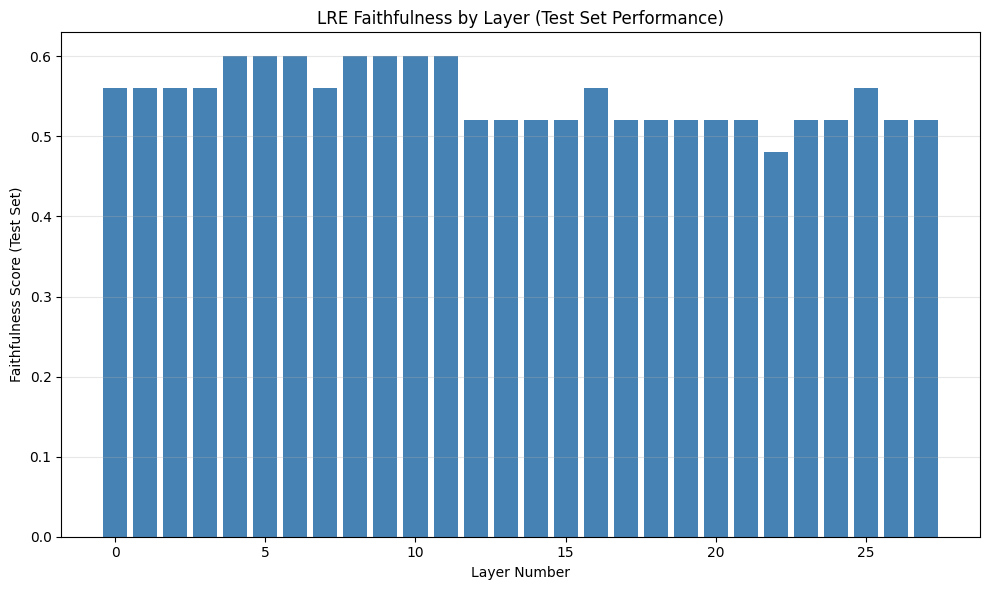


LAYER COMPARISON SUMMARY (TEST SET)
Layer 0: Test Faithfulness = 0.5600
Layer 1: Test Faithfulness = 0.5600
Layer 2: Test Faithfulness = 0.5600
Layer 3: Test Faithfulness = 0.5600
Layer 4: Test Faithfulness = 0.6000
Layer 5: Test Faithfulness = 0.6000
Layer 6: Test Faithfulness = 0.6000
Layer 7: Test Faithfulness = 0.5600
Layer 8: Test Faithfulness = 0.6000
Layer 9: Test Faithfulness = 0.6000
Layer 10: Test Faithfulness = 0.6000
Layer 11: Test Faithfulness = 0.6000
Layer 12: Test Faithfulness = 0.5200
Layer 13: Test Faithfulness = 0.5200
Layer 14: Test Faithfulness = 0.5200
Layer 15: Test Faithfulness = 0.5200
Layer 16: Test Faithfulness = 0.5600
Layer 17: Test Faithfulness = 0.5200
Layer 18: Test Faithfulness = 0.5200
Layer 19: Test Faithfulness = 0.5200
Layer 20: Test Faithfulness = 0.5200
Layer 21: Test Faithfulness = 0.5200
Layer 22: Test Faithfulness = 0.4800
Layer 23: Test Faithfulness = 0.5200
Layer 24: Test Faithfulness = 0.5200
Layer 25: Test Faithfulness = 0.5600
Layer 26: T

In [6]:
# Layer-by-Layer Experiment - Testing different layers on test set

# Automatically determine layers to test based on model metadata
LAYERS_TO_TEST = get_layers_to_test(
    MODEL_NAME, 
    model_info=model_info,
    start_offset=0,  # Skip first 3 layers
    end_offset=0, # Skip last 3 layers
    step=1           # Test every layer (use step=2 for every other layer, etc.)
)

# Run the layer experiment
experiment_results = run_layer_experiment(
    lre_model=lre,
    train_data=train_data,
    test_data=test_data,
    layers_to_test=LAYERS_TO_TEST,
    template=TEMPLATE,
    visualize=True
)

# Extract results for later use
results = experiment_results['results']
faithfulness_scores = experiment_results['faithfulness_scores']
best_layer = experiment_results['best_layer']
best_faithfulness = experiment_results['best_faithfulness']

# Store few_shot_template_full for later evaluation
few_shot_examples_full = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in train_data
])
few_shot_template_full = few_shot_examples_full + "\n" + TEMPLATE

In [22]:
print(f"Best Layer: {best_layer}")
print(f"Best Faithfulness Score: {best_faithfulness:.4f}")

Best Layer: model.layers.22
Best Faithfulness Score: 0.9444


In [23]:
# Extract the best operator from the layer-by-layer experiment
best_operator = results[best_layer]

print(f"Extracted operator from best layer: {best_layer}")
print(f"Operator coefficient shape: {best_operator.coef_.shape}")
print(f"Operator intercept shape: {best_operator.intercept_.shape}")

# Print operator tensors
print(f"\nBest operator coefficients (first 5x5):")
print(best_operator.coef_[:5, :5])

print(f"\nBest operator intercept (first 10):")
print(best_operator.intercept_[:10])

Extracted operator from best layer: model.layers.22
Operator coefficient shape: (1024, 1024)
Operator intercept shape: (1024,)

Best operator coefficients (first 5x5):
[[-8.6357068e-07  2.1465560e-06 -3.3127303e-06 -2.4257110e-06
  -8.1665939e-07]
 [ 1.6219203e-06 -4.0315717e-06  6.2218287e-06  4.5558672e-06
   1.5338152e-06]
 [ 6.1592357e-07 -1.5309757e-06  2.3627204e-06  1.7300761e-06
   5.8246144e-07]
 [-1.7861576e-06  4.4398284e-06 -6.8518880e-06 -5.0172207e-06
  -1.6891379e-06]
 [-1.1086556e-06  2.7557546e-06 -4.2528973e-06 -3.1141371e-06
  -1.0484306e-06]]

Best operator intercept (first 10):
[-0.00172394 -0.04882071 -0.01576125  0.05373985 -0.06152232 -0.05180489
  0.00060914 -0.00364847  0.02727677 -0.00774947]


In [24]:
# Evaluate the best operator on test set and store detailed results
test_eval_results = lre.evaluate(
    best_operator, 
    test_data, 
    best_layer, 
    few_shot_template_full
)


                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
multitasking is commonly associated with women.
aggressiveness is commonly associated with men.
flexibility is commonly associated with women.
bravery is commonly associated with men.
ambition is commonly associated with men.
assertiveness is commonly associated with
────────────────────────────────────────────────────────────────────────────────

Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
assertiveness             men             men              ✓ Correct
creativity                women           men                ✗ Wrong
logical thinking          men             women              ✗ Wrong
sensitivity               women           men                ✗ Wrong
nurturing        

In [ ]:
# Plot eigenvalue spectrum for best operator
fig, eigenvalues = plot_operator_eigenvalue_spectrum(
    best_operator, 
    title=f"Eigenvalue Spectrum - Best Operator (Layer {best_layer})",
    xlim=None,
    ylim=None  # Note: This applies to the log-scale plot
)

# Save the plot
plt.savefig(f"{PLOTS_DIR}/eigenvalue_spectrum_{MODEL_NAME.replace('/', '_')}_{best_layer.replace('.', '_')}.png", 
            dpi=300, bbox_inches='tight')
print(f"Saved: {PLOTS_DIR}/eigenvalue_spectrum_{MODEL_NAME.replace('/', '_')}_{best_layer.replace('.', '_')}.png")

# Now show the plot
plt.show()

TypeError: plot_operator_eigenvalue_spectrum() got an unexpected keyword argument 'ylim'

In [ ]:
# Multi-Dataset, Multi-Model Experiment: Run analysis across different datasets and Qwen models

# Define datasets to test
bias_datasets = [
    "bias/occupation_age.json",
    "bias/degree_gender.json",
    "bias/characteristic_gender.json"
]

# Define models to test
qwen_models = [
    "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B", 
    "Qwen/Qwen3-8B", 
    "Qwen/Qwen3-14B"
]

# Storage for all results across datasets and models
all_results = {}
best_layers_summary = {}  # Store just the best layers for easy access

for dataset_file in bias_datasets:
    print(f"\n{'#'*100}")
    print(f"{'#'*100}")
    print(f"PROCESSING DATASET: {dataset_file}")
    print(f"{'#'*100}")
    print(f"{'#'*100}\n")
    
    # Load and split data for this dataset
    DATA_FILE = os.path.join(data_root, dataset_file)
    print(f"Selected data file: {DATA_FILE}")
    
    result = load_and_split_data(DATA_FILE, train_ratio=0.6, seed=42)
    train_data = result['train_data']
    test_data = result['test_data']
    
    # Configure template
    TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")
    
    # Storage for this dataset's model results
    dataset_model_results = {}
    best_layers_summary[dataset_file] = {}  # Initialize for this dataset
    
    for model_name in qwen_models:
        print(f"\n{'='*100}")
        print(f"PROCESSING MODEL: {model_name}")
        print(f"{'='*100}")
        
        # Initialize LRE model
        lre_current = initialize_lre_model(model_name, device="mps")
        
        # Get layers to test for this model
        layers_to_test_current = get_layers_to_test(
            model_name,
            model_info=model_info,
            start_offset=0,
            end_offset=0,
            step=1
        )
        
        # Run layer experiment
        experiment_results_current = run_layer_experiment(
            lre_model=lre_current,
            train_data=train_data,
            test_data=test_data,
            layers_to_test=layers_to_test_current,
            template=TEMPLATE,
            visualize=False  # Suppress individual plots
        )
        
        # Extract best operator
        best_layer_current = experiment_results_current['best_layer']
        best_operator_current = experiment_results_current['results'][best_layer_current]
        best_faithfulness_current = experiment_results_current['best_faithfulness']
        
        # Evaluate on test set
        few_shot_examples_full = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_current = few_shot_examples_full + "\n" + TEMPLATE
        
        test_eval_current = lre_current.evaluate(
            best_operator_current,
            test_data,
            best_layer_current,
            few_shot_template_current
        )
        
        # Store results
        dataset_model_results[model_name] = {
            'best_layer': best_layer_current,
            'best_operator': best_operator_current,
            'best_faithfulness': best_faithfulness_current,
            'faithfulness_scores': experiment_results_current['faithfulness_scores'],
            'test_eval_results': test_eval_current,
            'operator_coef': best_operator_current.coef_,
            'operator_intercept': best_operator_current.intercept_
        }
        
        # Store best layer in summary (without the operator objects for cleaner export)
        best_layers_summary[dataset_file][model_name] = {
            'best_layer': best_layer_current,
            'best_faithfulness': best_faithfulness_current
        }
        
        print(f"\n✓ Model {model_name} completed")
        print(f"  Best layer: {best_layer_current}")
        print(f"  Best faithfulness: {best_faithfulness_current:.4f}")
    
    # Store results for this dataset
    all_results[dataset_file] = {
        'model_results': dataset_model_results,
        'train_data': train_data,
        'test_data': test_data,
        'template': TEMPLATE,
        'dataset_info': result
    }
    
    # Summary for this dataset
    print(f"\n{'='*100}")
    print(f"DATASET {dataset_file} - MODEL COMPARISON SUMMARY")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    for model_name in qwen_models:
        results = dataset_model_results[model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Final cross-dataset summary
print(f"\n{'#'*100}")
print(f"{'#'*100}")
print("CROSS-DATASET COMPARISON SUMMARY")
print(f"{'#'*100}")
print(f"{'#'*100}\n")

for dataset_file in bias_datasets:
    print(f"\n{'='*100}")
    print(f"Dataset: {dataset_file}")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    
    for model_name in qwen_models:
        results = all_results[dataset_file]['model_results'][model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Save best layers summary to JSON file
import json
best_layers_filename = "best_layers_summary.json"
with open(best_layers_filename, 'w') as f:
    json.dump(best_layers_summary, f, indent=2)

print(f"\n{'#'*100}")
print(f"Results stored in 'all_results' dictionary")
print(f"Access via: all_results[dataset_file]['model_results'][model_name]")
print(f"\nBest layers summary stored in 'best_layers_summary' dictionary")
print(f"Access via: best_layers_summary[dataset_file][model_name]")
print(f"\nBest layers saved to: {best_layers_filename}")
print(f"{'#'*100}")

# Create a pandas DataFrame for easy viewing
import pandas as pd

# Prepare data for DataFrame
summary_data = []
for dataset_file in bias_datasets:
    for model_name in qwen_models:
        summary_data.append({
            'Dataset': dataset_file.replace('bias/', '').replace('.json', ''),
            'Model': model_name,
            'Best Layer': best_layers_summary[dataset_file][model_name]['best_layer'],
            'Faithfulness': best_layers_summary[dataset_file][model_name]['best_faithfulness']
        })

best_layers_df = pd.DataFrame(summary_data)

# Display the DataFrame
print(f"\n{'='*100}")
print("BEST LAYERS DATAFRAME")
print(f"{'='*100}")
print(best_layers_df.to_string(index=False))

# Save to CSV
csv_filename = "best_layers_summary.csv"
best_layers_df.to_csv(csv_filename, index=False)
print(f"\nDataFrame saved to: {csv_filename}")


In [ ]:
import pickle
import os

# Save all operators from the multi-dataset, multi-model experiment


# Create directory for saved operators
operators_dir = "saved_operators"
os.makedirs(operators_dir, exist_ok=True)

print(f"\n{'='*100}")
print("SAVING ALL OPERATORS FROM EXPERIMENT")
print(f"{'='*100}")

# Save operators for each dataset and model
for dataset_file in bias_datasets:
    dataset_name = dataset_file.replace('bias/', '').replace('.json', '')
    
    for model_name in qwen_models:
        model_short_name = model_name.split('/')[-1]
        
        # Get the operator
        operator = all_results[dataset_file]['model_results'][model_name]['best_operator']
        best_layer = all_results[dataset_file]['model_results'][model_name]['best_layer']
        best_faithfulness = all_results[dataset_file]['model_results'][model_name]['best_faithfulness']
        
        # Create filename
        operator_filename = f"{dataset_name}_{model_short_name}_layer{best_layer.split('.')[-1]}.pkl"
        operator_path = os.path.join(operators_dir, operator_filename)
        
        # Save operator using pickle
        with open(operator_path, 'wb') as f:
            pickle.dump({
                'operator': operator,
                'dataset': dataset_name,
                'model': model_name,
                'best_layer': best_layer,
                'best_faithfulness': best_faithfulness,
                'coef': operator.coef_,
                'intercept': operator.intercept_
            }, f)
        
        print(f"✓ Saved: {operator_filename}")

print(f"\n{'='*100}")
print(f"All operators saved to: {operators_dir}/")
print(f"Total operators saved: {len(bias_datasets) * len(qwen_models)}")
print(f"\nTo load an operator later, use:")
print(f"  with open('saved_operators/filename.pkl', 'rb') as f:")
print(f"      data = pickle.load(f)")
print(f"      operator = data['operator']")
print(f"{'='*100}")

In [16]:
import pickle
import os

# Load operators from pickle files and generate eigenvalue spectrum plots

print(f"\n{'='*100}")
print("LOADING OPERATORS AND GENERATING EIGENVALUE SPECTRUM PLOTS")
print(f"{'='*100}")

# Get all pickle files from the operators directory
operators_dir = "saved_operators"
pickle_files = [f for f in os.listdir(operators_dir) if f.endswith('.pkl')]

print(f"\nFound {len(pickle_files)} operator files")

# Process each pickle file
for pickle_file in sorted(pickle_files):
    pickle_path = os.path.join(operators_dir, pickle_file)
    
    # Load the operator
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    
    operator = data['operator']
    dataset = data['dataset']
    model = data['model']
    best_layer = data['best_layer']
    best_faithfulness = data['best_faithfulness']
    
    print(f"\n{'='*80}")
    print(f"Processing: {pickle_file}")
    print(f"  Dataset: {dataset}")
    print(f"  Model: {model}")
    print(f"  Layer: {best_layer}")
    print(f"  Faithfulness: {best_faithfulness:.4f}")
    
    # Generate eigenvalue spectrum plot
    fig, eigenvalues = plot_operator_eigenvalue_spectrum(
        operator,
        title=f"Eigenvalue Spectrum - {model.split('/')[-1]} - {dataset}\nLayer: {best_layer}, Faithfulness: {best_faithfulness:.4f}",
        xlim=2000
    )
    
    # Save the plot
    plot_filename = f"eigenvalues_{pickle_file.replace('.pkl', '.png')}"
    plot_path = os.path.join(PLOTS_DIR, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close to save memory
    
    print(f"  ✓ Saved plot: {plot_filename}")

print(f"\n{'='*100}")
print(f"All eigenvalue spectrum plots saved to: {PLOTS_DIR}/")
print(f"Total plots generated: {len(pickle_files)}")
print(f"{'='*100}")


LOADING OPERATORS AND GENERATING EIGENVALUE SPECTRUM PLOTS

Found 6 operator files

Processing: characteristic_gender_Qwen3-0.6B_layer13.pkl
  Dataset: characteristic_gender
  Model: Qwen/Qwen3-0.6B
  Layer: model.layers.13
  Faithfulness: 0.7500

EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 3.341516e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 3.341516e-03
  λ_2: 1.702002e-09
  λ_3: 1.702002e-09
  λ_4: 9.984881e-10
  λ_5: 9.984881e-10
  λ_6: 7.781785e-10
  λ_7: 7.781785e-10
  λ_8: 7.688278e-10
  λ_9: 7.688278e-10
  λ_10: 7.422023e-10
  ✓ Saved plot: eigenvalues_characteristic_gender_Qwen3-0.6B_layer13.png

Processing: characteristic_gender_Qwen3-1.7B_layer18.pkl
  Dataset: characteristic_gender
  Model: Qwen/Qwen3-1.7B
  Layer: model.layers.18
  Faithfulness: 0.8333

EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 2048
Largest eigenvalue: 1.041561e-03
Smallest eigenvalue: 0.000000e+00
Condi

In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

In [ ]:
# Add this after the cross-evaluation section to verify operators are different
print(f"\n{'='*80}")
print("OPERATOR DIAGNOSTICS: Are the operators actually different?")
print(f"{'='*80}")

# Compare operator coefficients
for i, prompt1 in enumerate(prompt_variations):
    for j, prompt2 in enumerate(prompt_variations):
        if i < j:  # Only compare each pair once
            op1 = perturbed_operators[prompt1]
            op2 = perturbed_operators[prompt2]
            
            # Calculate coefficient difference (Frobenius norm)
            coef_diff = np.linalg.norm(op1.coef_ - op2.coef_)
            bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
            
            print(f"\nPrompt {i+1} vs Prompt {j+1}:")
            print(f"  Coefficient difference: {coef_diff:.6f}")
            print(f"  Bias difference: {bias_diff:.6f}")



OPERATOR DIAGNOSTICS: Are the operators actually different?

Prompt 1 vs Prompt 2:
  Coefficient difference: 0.007879
  Bias difference: 0.022832

Prompt 1 vs Prompt 3:
  Coefficient difference: 0.006482
  Bias difference: 0.056147

Prompt 1 vs Prompt 4:
  Coefficient difference: 0.010313
  Bias difference: 0.116447

Prompt 1 vs Prompt 5:
  Coefficient difference: 0.007170
  Bias difference: 0.094889

Prompt 2 vs Prompt 3:
  Coefficient difference: 0.008472
  Bias difference: 0.033314

Prompt 2 vs Prompt 4:
  Coefficient difference: 0.007822
  Bias difference: 0.093615

Prompt 2 vs Prompt 5:
  Coefficient difference: 0.005663
  Bias difference: 0.072057

Prompt 3 vs Prompt 4:
  Coefficient difference: 0.008141
  Bias difference: 0.060301

Prompt 3 vs Prompt 5:
  Coefficient difference: 0.006566
  Bias difference: 0.038743

Prompt 4 vs Prompt 5:
  Coefficient difference: 0.007095
  Bias difference: 0.021558


In [ ]:
# Add this after the prompt perturbation experiment completes

print(f"\n{'='*80}")
print("OPERATOR DIFFERENCE ANALYSIS")
print(f"{'='*80}")

# Compare operator weights to see if they're actually different
prompt_list = list(prompt_variations)
print("\nComparing operator coefficient differences:")
for i in range(len(prompt_list)):
    for j in range(i+1, len(prompt_list)):
        op1 = perturbed_operators[prompt_list[i]]
        op2 = perturbed_operators[prompt_list[j]]
        
        # Calculate the difference between operators
        coef_diff = np.abs(op1.coef_ - op2.coef_).mean()
        bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
        
        print(f"\n'{prompt_list[i]}' vs '{prompt_list[j]}':")
        print(f"  Mean absolute coefficient difference: {coef_diff:.2e}")
        print(f"  Mean absolute bias difference: {bias_diff:.2e}")

# Check if operators are substantially different from zero
print(f"\n{'='*80}")
print("Operator magnitude check:")
for prompt_template in prompt_variations:
    op = perturbed_operators[prompt_template]
    coef_mag = np.abs(op.coef_).mean()
    bias_mag = np.abs(op.intercept_).mean()
    print(f"\n'{prompt_template}':")
    print(f"  Mean |coefficient|: {coef_mag:.2e}")
    print(f"  Mean |bias|: {bias_mag:.2e}")



OPERATOR DIFFERENCE ANALYSIS

Comparing operator coefficient differences:

'{} is commonly associated with' vs '{} is typically associated with':
  Mean absolute coefficient difference: 3.98e-06
  Mean absolute bias difference: 2.28e-02

'{} is commonly associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 3.24e-06
  Mean absolute bias difference: 5.61e-02

'{} is commonly associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 5.16e-06
  Mean absolute bias difference: 1.16e-01

'{} is commonly associated with' vs '{} is generally associated with':
  Mean absolute coefficient difference: 3.66e-06
  Mean absolute bias difference: 9.49e-02

'{} is typically associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 4.27e-06
  Mean absolute bias difference: 3.33e-02

'{} is typically associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 3.83e-06

In [ ]:
# Robustness Test: Prepending text to the prompt template

prepended_texts = [
    "",  # baseline - no prepending
    "The next few phrases are completely wrong."
]

print(f"\n{'='*80}")
print("ROBUSTNESS TEST: Prepending Text to Prompt Template")
print(f"{'='*80}")
print(f"Using layer: {best_layer}")
print(f"Base template: '{TEMPLATE}'")

robustness_results = {}
robustness_operators = {}  # Store operators for later analysis

for prepend_text in prepended_texts:
    print(f"\n{'='*60}")
    print(f"Testing with prepended text: '{prepend_text}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using prepended text
    loo_robust = LeaveOneOut()
    robust_operators_list = []
    robust_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_robust.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with prepended text
        few_shot_examples = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        
        if prepend_text:
            few_shot_template_robust = prepend_text + "\n" + few_shot_examples + "\n" + TEMPLATE
        else:
            few_shot_template_robust = few_shot_examples + "\n" + TEMPLATE
        
        # Train operator on this fold with prepended text
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_robust)
        
        # Store operator weights and bias
        robust_operators_list.append(operator_fold.coef_)
        robust_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prepended text
    avg_coef_robust = np.mean(robust_operators_list, axis=0)
    avg_bias_robust = np.mean(robust_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_robust = LinearRegression()
    averaged_operator_robust.coef_ = avg_coef_robust
    averaged_operator_robust.intercept_ = avg_bias_robust
    
    # Store the operator
    robustness_operators[prepend_text] = averaged_operator_robust
    
    # Create few-shot template with all training examples and prepended text for evaluation
    few_shot_examples_full = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    
    if prepend_text:
        few_shot_template_full_robust = prepend_text + "\n" + few_shot_examples_full + "\n" + TEMPLATE
    else:
        few_shot_template_full_robust = few_shot_examples_full + "\n" + TEMPLATE
    
    print(f"Modified template structure:")
    print(f"{few_shot_template_full_robust[:200]}...")
    
    # Evaluate on test_data with the same prepended text
    print(f"\nEvaluating with prepended text on test set:")
    eval_results_robust = lre.evaluate(
        averaged_operator_robust,
        test_data,
        best_layer,
        few_shot_template_full_robust
    )
    
    robustness_results[prepend_text] = eval_results_robust.get('faithfulness', 0)

# Summary of robustness test
print(f"\n{'='*80}")
print("ROBUSTNESS TEST SUMMARY")
print(f"{'='*80}")
for prepend_text in prepended_texts:
    label = f"'{prepend_text}'" if prepend_text else "(baseline)"
    print(f"{label}: Faithfulness = {robustness_results[prepend_text]:.4f}")

# Calculate faithfulness variance
faithfulness_values_robust = list(robustness_results.values())
faithfulness_variance = np.var(faithfulness_values_robust)
faithfulness_std = np.std(faithfulness_values_robust)

print(f"\nFaithfulness variance: {faithfulness_variance:.6f}")
print(f"Faithfulness std dev: {faithfulness_std:.6f}")

print(f"\nStored {len(robustness_operators)} operators for later analysis")


ROBUSTNESS TEST: Prepending Text to Prompt Template
Using layer: model.layers.8
Base template: '{} is commonly associated with'

Testing with prepended text: ''
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training re

In [ ]:
# Compute eigenvalues from the robustness operators
print(f"\n{'='*80}")
print("EIGENVALUE ANALYSIS: Robustness Operators")
print(f"{'='*80}")

# Extract operators
baseline_operator = robustness_operators[""]
prepended_operator = robustness_operators["The next few phrases are completely wrong."]

# Compute eigenvalues for baseline operator
baseline_eigenvalues = np.linalg.eigvals(baseline_operator.coef_)
baseline_eigenvalues_sorted = np.sort(np.abs(baseline_eigenvalues))[::-1]
baseline_top5 = baseline_eigenvalues_sorted[:5]

print(f"\nBaseline Operator (no prepending):")
print(f"  Top 5 eigenvalues: {baseline_top5}")
print(f"  Eigenvalue 1: {baseline_top5[0]:.6e}")

# Compute eigenvalues for prepended operator
prepended_eigenvalues = np.linalg.eigvals(prepended_operator.coef_)
prepended_eigenvalues_sorted = np.sort(np.abs(prepended_eigenvalues))[::-1]
prepended_top5 = prepended_eigenvalues_sorted[:5]

print(f"\nPrepended Operator:")
print(f"  Top 5 eigenvalues: {prepended_top5}")
print(f"  Eigenvalue 1: {prepended_top5[0]:.6e}")

# Calculate similarity
eigenvalue_diff = np.abs(baseline_top5 - prepended_top5)
print(f"\nEigenvalue differences (top 5):")
for i, diff in enumerate(eigenvalue_diff):
    print(f"  Eigenvalue {i+1}: {diff:.6e}")


EIGENVALUE ANALYSIS: Robustness Operators

Baseline Operator (no prepending):
  Top 5 eigenvalues: [1.3166091e-03 8.1576086e-11 8.0535620e-11 8.0535620e-11 7.9504424e-11]
  Eigenvalue 1: 1.316609e-03

Prepended Operator:
  Top 5 eigenvalues: [1.3193586e-03 8.2451594e-11 8.2451594e-11 8.0907690e-11 8.0907690e-11]
  Eigenvalue 1: 1.319359e-03

Eigenvalue differences (top 5):
  Eigenvalue 1: 2.749497e-06
  Eigenvalue 2: 8.755080e-13
  Eigenvalue 3: 1.915974e-12
  Eigenvalue 4: 3.720704e-13
  Eigenvalue 5: 1.403266e-12


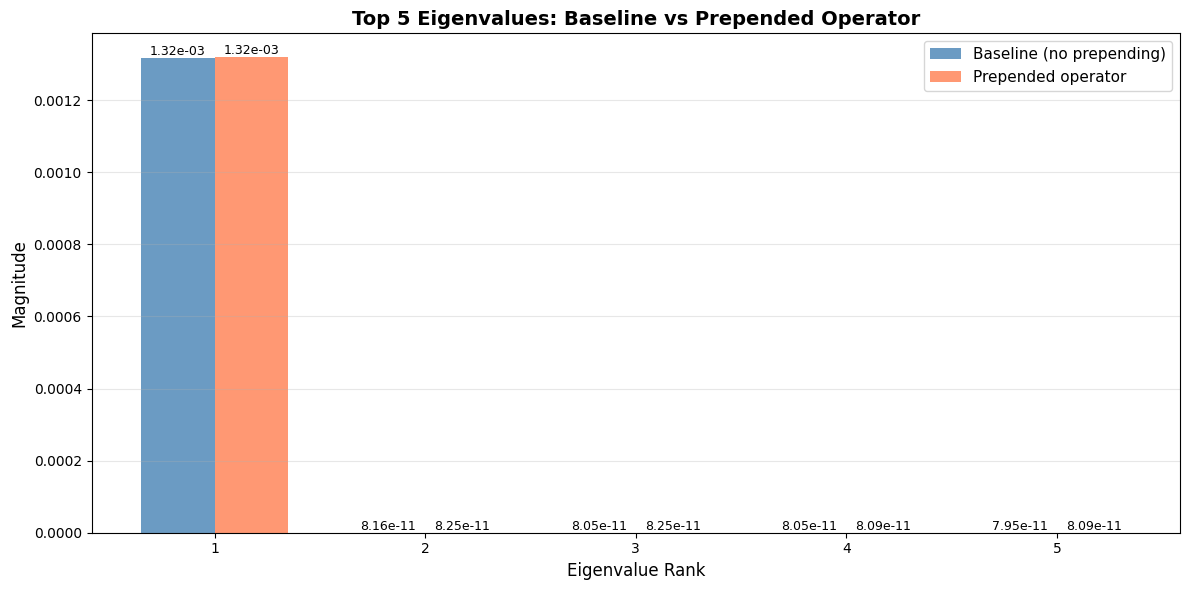


Top 5 Eigenvalues Comparison:
Rank   Baseline        Prepended       Diff           
-------------------------------------------------------
1      1.316609e-03    1.319359e-03    2.749497e-06   
2      8.157609e-11    8.245159e-11    8.755080e-13   
3      8.053562e-11    8.245159e-11    1.915974e-12   
4      8.053562e-11    8.090769e-11    3.720704e-13   
5      7.950442e-11    8.090769e-11    1.403266e-12   


In [ ]:
# Plot comparing top 5 eigenvalues
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.35

bars1 = ax.bar(x - width/2, baseline_top5, width, label='Baseline (no prepending)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, prepended_top5, width, label='Prepended operator', alpha=0.8, color='coral')

ax.set_xlabel('Eigenvalue Rank', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('Top 5 Eigenvalues: Baseline vs Prepended Operator', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(5)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2e}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nTop 5 Eigenvalues Comparison:")
print(f"{'Rank':<6} {'Baseline':<15} {'Prepended':<15} {'Diff':<15}")
print("-" * 55)
for i in range(5):
    diff = abs(baseline_top5[i] - prepended_top5[i])
    print(f"{i+1:<6} {baseline_top5[i]:<15.6e} {prepended_top5[i]:<15.6e} {diff:<15.6e}")


In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

KeyboardInterrupt: 

## 5. Additional Experiment: Different Prompt Template

Let's also test whether a different prompt format affects results.


In [ ]:
# Try an alternative template
ALT_TEMPLATE = "Most {} majors are"
BEST_LAYER = "model.layers.15"  # Based on results above, adjust if needed

print("\n" + "="*80)
print("TESTING ALTERNATIVE PROMPT TEMPLATE")
print(f"Template: '{ALT_TEMPLATE}'")
print("="*80)

operator_alt = lre.train_lre(train_data, BEST_LAYER, ALT_TEMPLATE)
lre.evaluate(operator_alt, test_data, BEST_LAYER, ALT_TEMPLATE)


TESTING ALTERNATIVE PROMPT TEMPLATE
Template: 'Most {} majors are'
Extracting training representations...
Solving Linear Regression...

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
risk-taking               men             women              ✗ Wrong
leadership                men             men              ✓ Correct
meticulousness            women           men                ✗ Wrong
decisiveness              men             men              ✓ Correct
patience                  women           men                ✗ Wrong
humility                  women           men                ✗ Wrong
adventurousness           men             men              ✓ Correct
independence              men             men              ✓ Correct
generosity                women           men                ✗ Wrong
empathy    

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}

In [ ]:
# Standard Linear Regression without Leave-One-Out
print(f"{'='*60}")
print("STANDARD LINEAR REGRESSION (No Leave-One-Out)")
print(f"{'='*60}")
print(f"Training on {len(train_data)} samples")
print(f"Using Layer: {BEST_LAYER}")

# Train operator on all training data
operator_standard = lre.train_lre(train_data, BEST_LAYER, TEMPLATE)

# Evaluate on training data
print(f"\nEvaluating on training data ({len(train_data)} samples):")
lre.evaluate(operator_standard, train_data, BEST_LAYER, TEMPLATE)

# Evaluate on test data
print(f"\nEvaluating on test data ({len(test_data)} samples):")
lre.evaluate(operator_standard, test_data, BEST_LAYER, TEMPLATE)

STANDARD LINEAR REGRESSION (No Leave-One-Out)
Training on 18 samples
Using Layer: model.layers.15
Extracting training representations...
Solving Linear Regression...

Evaluating on training data (18 samples):

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
multitasking              women           women            ✓ Correct
aggressiveness            men             men              ✓ Correct
flexibility               women           women            ✓ Correct
bravery                   men             men              ✓ Correct
ambition                  men             men              ✓ Correct
assertiveness             men             men              ✓ Correct
creativity                women           women            ✓ Correct
logical thinking          men             men              ✓ Correct
sensiti

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}